## Torch Imports

In [1]:
# Ml package Inports
import torch
import torch.nn as nn
import torchvision
from torchsummary import summary
import torchvision.models as models
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import Dataset
# import torch.optim.lr_scheduler as lr_scheduler
# from torch.autograd import Variable
# from torch.nn.functional import interpolate

## Helper Imports

In [2]:
# install neccessary packages
!pip install segmentation-models-pytorch
!pip install pytorch-msssim
!pip install kornia

In [3]:
# Helper package Imports
import segmentation_models_pytorch as smp
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from pytorch_msssim import SSIM, MS_SSIM, ssim, ms_ssim
from zipfile import ZipFile
import os
from PIL import Image, ImageOps
from pathlib import Path
import shutil
import time
from tqdm.notebook import tqdm, trange
from kornia.color import rgb_to_lab, bgr_to_rgb, lab_to_rgb
%matplotlib inline

## Kaggle Dataset Import

In [4]:
!pip install kaggle

In [5]:
!kaggle datasets download -d mariomatos/image-colorization

image-colorization.zip: Skipping, found more recently modified local copy (use --force to force download)


## Image Dimension and Batch Size

In [6]:
img_dim = 256
batch_size = 4

## Data Extract

In [7]:
# Directories
data_path = "./Data/"

In [8]:
# Extracting Dataset and renameing folder
if not Path(data_path).is_dir():
    # Extract Data From Zip File
    with ZipFile('image-colorization.zip',"r") as z:
        z.extractall(path = data_path)
    old_path = data_path + str(os.listdir(data_path)[0])
    
    image_paths = [f'{old_path}/{img}' for img in os.listdir(old_path)]
    
    # Change Data Directory to ./Data/...
    print("Changing Image Directory >>")
    for i in trange(len(image_paths)):
        shutil.move(image_paths[i], data_path)
    
    os.rmdir(old_path)
    image_paths = [f'{data_path}{img}' for img in os.listdir(data_path)]
    print(f"Total Images Ectracted from the Dataset\t\t: {len(image_paths)}")
    
    # Remove Grayscale Images
    print("Removing Grayscale Images >>")
    for i in trange(len(image_paths)):
        img = cv2.imread(image_paths[i])
        img = torch.from_numpy(img).permute(2,0,1)        
        
        if torch.mean(((img[0] == img[1]) == (img[1] == img[2])).float()) == 1:
            os.remove(image_paths[i])
    
    print(f"Total Images after Removing Grayscale Images\t: {len(os.listdir(data_path))}")

## Data Sample

In [9]:
# filename check
imgs = os.listdir(data_path)
print(f'Total Images : {len(imgs)}')
print(f'Sample Image Name : {imgs[random.randint(0, len(imgs))]}')

Total Images : 10504
Sample Image Name : 000000256825.jpg


## Helper Methods

In [10]:
def ab_Norm(ab_x):
    ab = torch.clone(ab_x)
    ab = ab * 128
    return ab.long()

def ab_UnNorm(ab_x):
    ab = torch.clone(ab_x)
    ab = ab / 128
    return ab.float()

def l_Norm(l_x):
    l = torch.clone(l_x)
    l = (l * 100) + 50
    return l.long()

def l_UnNorm(l_x):
    l = torch.clone(l_x)
    l = (l - 50) / 100
    return l.float()

def fullImg(inp, tar):
    return torch.cat((inp, tar), 0)

def getRGB(img):
    x = torch.clone(img)
    x[0] = (x[0] * 100) + 50
    x[1:] = x[1:] * 128
    return (lab_to_rgb(x) * 255).long() 

def getRGBs(img):
    x = torch.clone(img)
    x[0:, 0, 0:, 0:] = (x[0:, 0, 0:, 0:] * 100) + 50
    x[0:, 1:, 0:, 0:] = x[0:, 1:, 0:, 0:] * 128
    return (lab_to_rgb(x) * 255).float()

## Building Dataset

In [11]:
# create dataset
class DatasetBNW(Dataset):
    def __init__(self, path=data_path, transform=None):
        self.data = [f'{path}{img}' for img in os.listdir(path)]
        self.length = len(self.data)
        self.transform = transform

    def __getitem__(self, index):
        img = cv2.imread(self.data[index])
        img = cv2.resize(img, (img_dim, img_dim))
        
        img = torch.from_numpy(img).permute(2,0,1)
        
        img = bgr_to_rgb(img) / 255
        img = rgb_to_lab(img)
    
        input_img = img[0,0:,0:].view(1,img_dim,img_dim)
        input_img = l_UnNorm(input_img)
        
        target_img = img[1:,0:,0:]
        target_img = ab_UnNorm(target_img)
        
        return input_img, target_img
    
    def __len__(self):
        return len(self.data)

In [12]:
# DataSet
dataset = DatasetBNW()
len(dataset.data)

10504

## Sample Dataset Image

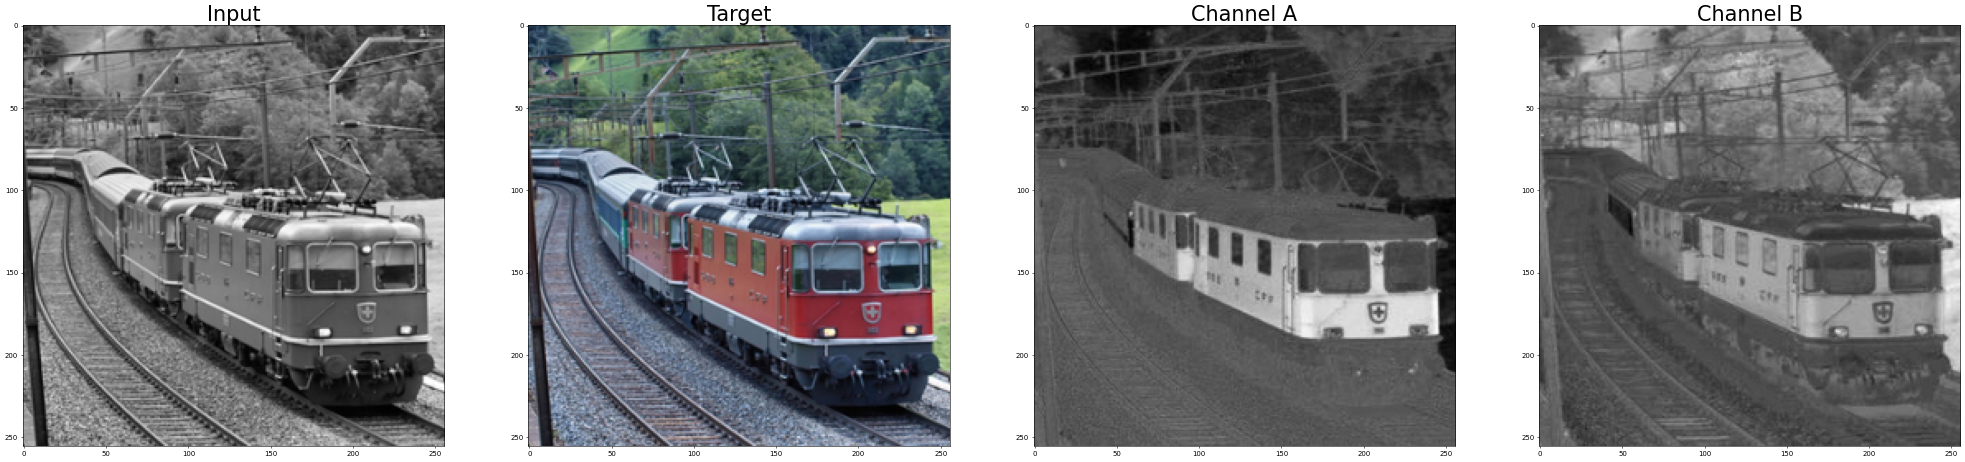

In [13]:
inp, tar = dataset[random.randint(0, len(dataset))]
f = fullImg(inp, tar)
full = getRGB(f)

plt.figure(figsize=(50,50), dpi=50)

plt.subplot(241)
plt.title('Input', fontdict = {'fontsize': 30})
plt.imshow(inp.permute(1,2,0), cmap = 'gray')

plt.subplot(242)
plt.title('Target', fontdict = {'fontsize': 30})
plt.imshow(full.permute(1,2,0), cmap = 'gray')

plt.subplot(243)
plt.title('Channel A', fontdict = {'fontsize': 30})
plt.imshow(tar[0,0:,0:].view(1,img_dim,img_dim).permute(1,2,0), cmap = 'gray')

plt.subplot(244)
plt.title('Channel B', fontdict = {'fontsize': 30})
plt.imshow(tar[1,0:,0:].view(1,img_dim,img_dim).permute(1,2,0), cmap = 'gray')

## DataLoaders

In [14]:
# split data into train, validation and test data
def split_indices(n, val_pct, test_pct, seed=65):
    # determine the size of the validation set, test set
    n_val = int(val_pct*n)
    n_test = int(test_pct*n + n_val)
    # print(n_val, n_test, n_train)
    # create random parmutation of 0 to n-1
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    # pick data as train[start-val], validation[val-test] and test[test-end]
    return idxs[n_test:], idxs[:n_val], idxs[n_val:n_test]

In [15]:
# split the dataset into training, validation and test set
train_indices, val_indices, test_indices = split_indices(len(dataset), 0.2, 0.1)
print(f"""
        Training Images   : {len(train_indices)}\n
        Validation Images : {len(val_indices)}\n
        Testing Images    : {len(test_indices)}\n
        Total Images      : {len(train_indices) + len(val_indices) + len(test_indices)}""")


        Training Images   : 7354

        Validation Images : 2100

        Testing Images    : 1050

        Total Images      : 10504


In [16]:
# training sampler and dataloader
train_sampler = SubsetRandomSampler(train_indices)    # takes samples w.r.t the indices
train_dl = DataLoader(dataset,
                      batch_size,
                      sampler = train_sampler)

In [17]:
# validation sampler and dataloader
val_sampler = SubsetRandomSampler(val_indices)        # takes samples w.r.t the indices
val_dl = DataLoader(dataset,
                    batch_size,
                    sampler = val_sampler)

In [18]:
# test sampler and dataloader
test_sampler = SubsetRandomSampler(test_indices)        # takes samples w.r.t the indices
test_dl = DataLoader(dataset,
                     batch_size,
                     sampler = test_sampler)

## Loss and Accuracy Holder

In [19]:
val_accuracies = []
val_losses = []

## Show and Print Result

In [20]:
def pltSubpot(cord, pos, cp, title, pic, titleShow = True):
    plt.subplot2grid(cord, pos, colspan=cp)
    plt.axis('off')
    if titleShow:
        plt.title(title, fontdict = {'fontsize': 20})    
    plt.imshow(pic, cmap = plt.cm.gray)

In [21]:
def testResult(t_model, idx = None, savePath = None, name = None, show = True):
    if idx == None:
        inp, tgt = dataset[(random.choices(list(test_sampler.indices))[0])]
    else:
        inp, tgt = dataset[list(test_sampler.indices)[idx]]
    
    out = t_model(inp.unsqueeze(0).cuda())
    out = out.squeeze(0).cpu()
    
    target = fullImg(inp, tgt)
    
    if not Path(f'{savePath}').is_dir():
        Path.mkdir(Path(f'{savePath}'))
        
    fig = plt.figure(figsize=(25,25), dpi=45)
    
    graph_dim = (3, 6)
    
    # input
    pltSubpot(graph_dim, (0, 0), 2, 'Input', inp.permute(1,2,0))
    
    # target
    pltSubpot(graph_dim, (0, 2), 2, 'Target', getRGB(target).permute(1,2,0))
    
    # output
    pltSubpot(graph_dim, (0, 4), 2, 'Output', getRGB(out).permute(1,2,0))
    
    if name != None:
        # target L
        pltSubpot(graph_dim, (1, 0), 2, 'target L Channel', target[0,0:,0:].cpu())

        # target A
        pltSubpot(graph_dim, (1, 2), 2, 'target A Channel', target[1,0:,0:].cpu())

        # target B
        pltSubpot(graph_dim, (1, 4), 2, 'target B Channel', target[2,0:,0:].cpu())

        # output L
        pltSubpot(graph_dim, (2, 0), 2, 'Output L Channel', out[0,0:,0:].cpu().detach())

        # output A
        pltSubpot(graph_dim, (2, 2), 2, 'Output A Channel', out[1,0:,0:].cpu().detach())

        # output B
        pltSubpot(graph_dim, (2, 4), 2, 'Output B Channel', out[2,0:,0:].cpu().detach())        
        
    else:
        # target L
        pltSubpot(graph_dim, (1, 0), 1, 'target L Channel', target[0,0:,0:].cpu())

        # target A
        pltSubpot(graph_dim, (1, 1), 1, 'target A Channel', target[1,0:,0:].cpu())

        # target B
        pltSubpot(graph_dim, (1, 2), 1, 'target B Channel', target[2,0:,0:].cpu())

        # output L
        pltSubpot(graph_dim, (1, 3), 1, 'Output L Channel', out[0,0:,0:].cpu().detach())

        # output A
        pltSubpot(graph_dim, (1, 4), 1, 'Output A Channel', out[1,0:,0:].cpu().detach())

        # output B
        pltSubpot(graph_dim, (1, 5), 1, 'Output B Channel', out[2,0:,0:].cpu().detach())
        
        # Validation Loss Graph
        plt.subplot2grid(graph_dim, (2, 0), colspan=3)
        plt.plot(val_accuracies, label = 'Validation Accuracy')
        plt.xlabel('Epoch', fontdict = {'fontsize': 15})
        plt.title('Accuracy', fontdict = {'fontsize': 20})
        plt.legend(fontsize='x-large')

        # Validation Loss Graph
        plt.subplot2grid(graph_dim, (2, 3), colspan=3)
        plt.plot(val_losses, label = 'Validation Loss')
        plt.xlabel('Epoch', fontdict = {'fontsize': 15})
        plt.title('Loss', fontdict = {'fontsize': 20})
        plt.legend(fontsize='x-large')
    
    plt.tight_layout()
    
    if savePath != None:
        if name == None:
            plt.savefig(f'{savePath}/result.jpg')
        else:
            plt.savefig(f'{savePath}/{name}.jpg')
    
    if not show:
        plt.close(fig)
        print('Plot Saved')

In [22]:
def modelSampleOut(t_model, idx = [1,2,3,4,5], savePath = None, saveTarget = False, result = None, show = False, realLife = None):
    if realLife == None:
        inp_list = tuple([dataset[list(test_sampler.indices)[j]][0] for j in idx])
        inp_list = torch.stack(inp_list)
    else:
        inp_list = realLife.cuda()
    
    if saveTarget:
        inp = tuple([dataset[list(test_sampler.indices)[j]][0] for j in idx])
        inp = torch.stack(inp)
        
        tgt = tuple([dataset[list(test_sampler.indices)[j]][1] for j in idx])
        tgt = torch.stack(tgt)
        
        out = torch.cat((inp, tgt), 1)
    else:
        out = t_model(inp_list.cuda())
        out = out.cpu()
    
    fig = plt.figure(figsize=(35,5), dpi=45)
    
    graph_dim = (1, 7)
    
    if not Path(f'{savePath}').is_dir():
        Path.mkdir(Path(f'{savePath}'))
    
    if not saveTarget:
        # Model Info Label
        plt.subplot2grid(graph_dim, (0, 0), colspan=1)
        if result != None:
            plt.text(.3, .5, 
                     modelInfo(2, ['Test Loss', 'Test Accuracy']), 
                     dict(size=25),  
                     verticalalignment='center')
        else:
            plt.text(.3, .5, 
                     modelInfo(2), 
                     dict(size=25),  
                     verticalalignment='center')
        plt.axis('off')

        # Model Info Label
        plt.subplot2grid(graph_dim, (0, 1), colspan=1)
        if result != None:
            plt.text(.3, .5, 
                     modelInfo(3, result), 
                     dict(size=25),  
                     verticalalignment='center')
        else:
            plt.text(.3, .5, 
                     modelInfo(3), 
                     dict(size=25),  
                     verticalalignment='center')
        plt.axis('off')
    else:
        plt.subplot2grid(graph_dim, (0, 0), colspan=2)
        plt.text(0.5, 0.5, 
                 "Target Images", 
                 dict(size=25),
                 horizontalalignment='center',
                 verticalalignment='center')
        plt.axis('off')
    
    # sample 1
    pltSubpot(graph_dim, (0, 2), 1, 'Sample 1', getRGB(out[0]).permute(1,2,0), titleShow=False)
    
    # sample 2
    pltSubpot(graph_dim, (0, 3), 1, 'Sample 2', getRGB(out[1]).permute(1,2,0), titleShow=False)
    
    # sample 3
    pltSubpot(graph_dim, (0, 4), 1, 'Sample 3', getRGB(out[2]).permute(1,2,0), titleShow=False)
    
    # sample 4
    pltSubpot(graph_dim, (0, 5), 1, 'Sample 4', getRGB(out[3]).permute(1,2,0), titleShow=False)
    
    # sample 5
    pltSubpot(graph_dim, (0, 6), 1, 'Sample 5', getRGB(out[4]).permute(1,2,0), titleShow=False)
    
    plt.tight_layout(pad=1.0, h_pad=1.0)
    
    if realLife != None:
        outputFile = 'RealOut'
    else:
        outputFile = 'SampleOutputs'
        
    if saveTarget:
        plt.savefig(f'{savePath}/Targets.jpg')
    else:
        plt.savefig(f'{savePath}/{outputFile}.jpg')
    
    if not show:
        plt.close(fig)
        print('Plot Saved')

In [23]:
def samplesOut(t_model, idx = [1,2,3,4,5], savePath = None, saveTarget = False, show = False, grayScale = False, realLife = None):
    if realLife == None:
        inp_list = tuple([dataset[list(test_sampler.indices)[j]][0] for j in idx])
        inp_list = torch.stack(inp_list)
    else:
        inp_list = realLife
    
    if saveTarget:
        inp = tuple([dataset[list(test_sampler.indices)[j]][0] for j in idx])
        inp = torch.stack(inp)
        
        tgt = tuple([dataset[list(test_sampler.indices)[j]][1] for j in idx])
        tgt = torch.stack(tgt)
        
        out = torch.cat((inp, tgt), 1)
    else:
        out = t_model(inp_list.cuda())
        out = out.cpu()
    
    if not Path(f'{savePath}').is_dir():
        Path.mkdir(Path(f'{savePath}'))
    
    if not Path(f'./TargetSample').is_dir():
        Path.mkdir(Path(f'./TargetSample'))
    
    if not Path(f'./InputSample').is_dir():
        Path.mkdir(Path(f'./InputSample'))
    
    if grayScale:
        for i, inpt in enumerate(inp_list):
            fig = plt.figure(figsize=(10, 10), dpi=45)

            graph_dim = (1, 1)

            # sample 1
            pltSubpot(graph_dim, (0, 0), 1, '', inpt.permute(1,2,0), titleShow=False)

            plt.tight_layout(pad=1.0, h_pad=1.0)  
            
            if realLife == None:
                plt.savefig(f'./InputSample/G{i+1}.jpg')
            else:
                plt.savefig(f'./RealTest/{i+1}.jpg')
                
            if not show:
                plt.close(fig)
                print('Plot Saved')
    else:
        for i, o in enumerate(out):
            fig = plt.figure(figsize=(10, 10), dpi=45)

            graph_dim = (1, 1)

            # sample 1
            pltSubpot(graph_dim, (0, 0), 1, '', getRGB(o).permute(1,2,0), titleShow=False)

            plt.tight_layout(pad=1.0, h_pad=1.0)  
            
            if realLife != None:
                fn = 'R'
            else:
                fn = 'S'
                
            if saveTarget:
                plt.savefig(f'./TargetSample/T{i+1}.jpg')
            else:
                plt.savefig(f'{savePath}/{fn}{i+1}.jpg')

            if not show:
                plt.close(fig)
                print('Plot Saved')

## Save and Load Model Data

In [24]:
# Loading previous losses and accuracies
def loadModelData(directory='./Saved/'):
    acc = []
    los = []
    if not Path('./Saved').is_dir():
        Path.mkdir(Path('./Saved'))
        
    if Path(directory).is_dir():
        if os.path.exists(f'{directory}/modelParams.pth'):
            model.load_state_dict(torch.load(f'{directory}/modelParams.pth'))
    else:
        Path.mkdir(Path(directory))
        
    try:
        with open(f'{directory}/accuracies.txt', 'r') as fd:
            acc = [float(acc.rstrip()) for acc in fd.readlines()]

        with open(f'{directory}/losses.txt', 'r') as fd:
            los = [float(losses.rstrip()) for losses in fd.readlines()]
    except IOError:
        print('file not Found')
    
    return acc, los

In [25]:
# save the model parameters to the disk
def saveModelData(directory='./Saved/', testScore = None):
    torch.save(model.state_dict(), f'{directory}/modelParams.pth')
    
    if testScore != None:
        with open(f'{directory}/testScore.txt', 'w') as fd:
                fd.writelines(f"{i}\n" for i in testScore)
            
    with open(f'{directory}/accuracies.txt', 'w') as fd:
            fd.writelines(f"{acc:.10f}\n" for acc in val_accuracies)

    with open(f'{directory}/losses.txt', 'w') as fd:
        fd.writelines(f"{losses:.10f}\n" for losses in val_losses) 

## Model Spcifications

In [26]:
# arch = "Unet++"                # Unet, Unet++
# encoder = "resnet152"          # resnet18, resnet34, resnet50, resnet101, resnet152, inceptionresnetv2, efficientnet_b6, dpn98
# colorsspace = "LAB"            # Lab, RGB
# loss_fn = "MSELoss+MS-SSIM"    # MS-SSIM, MSELoss, MSELoss+MS-SSIM
# embedding = "vgg16"            # none, resnet50, vgg16
# enc_wei = "imagenet"           # imagenet, swsl, ssl

In [27]:
def modelInfo(choice = 1, result = None):
    info = ''
    if choice == 1:
        info = f"Architecture\t: {arch}\nEncoder\t\t: {encoder}\nLoss in ColorSpace\t: {colorsspace}\nLoss Function\t: {loss_fn}\nEmbedding\t: {embedding}\nEncoder Weights\t: {enc_wei}"
        return 
    elif choice == 2:
        info = f"Architecture\nEncoder\nLoss in ColorSpace\nLoss Function\nEmbedding\nEncoder Weights"
        if result != None:
            for i in result:
                info = info+f'\n{i}'
    else:
        info = f": {arch}\n: {encoder}\n: {colorsspace}\n: {loss_fn}\n: {embedding}\n: {enc_wei}"
        if result != None:
            for i in result:
                info = info+f'\n: {i}'
    
    return info

## Load Model Specification

In [28]:
def specFromName(name):
    spec = name.split('_')
    return [spec[0], spec[1].lower(), spec[2], spec[3], spec[4].lower(), spec[5].lower()]

In [29]:
model_dir = './Saved/'
if Path(model_dir).is_dir():
    model_data_folders = os.listdir(model_dir)

In [30]:
specs = {}

if Path(model_dir).is_dir() and len(model_data_folders) > 0:
    print('Choose a Model >>\n')
    for i, md in enumerate(model_data_folders):
        print(f'{(i+1):2d}. {md}')
    
    print(f'{(len(model_data_folders)+1):2d}. Add New Model')

    user_choice = True
    if user_choice:
        md_in = int(input('Choice: '))
    else:
        md_in = int(5)
    
    if md_in < len(model_data_folders)+1:
        model_data = model_data_folders[md_in-1]
        arch, encoder, colorsspace, loss_fn, embedding, enc_wei = specFromName(model_data)
    else:
        print('Add a Model >>\n')
        arch = str(input('Architecture: ')).capitalize()
        encoder = str(input('Encoder: ')).capitalize()
        colorsspace = str(input('Color Space: ')).upper()
        loss_fn = str(input('Loss Function: ')).upper()
        embedding = str(input('Embedding: ')).capitalize()
        enc_wei = str(input('Encoder Weights: ')).capitalize()

    specs = {'arch' : arch,
             'encoder' : encoder,
             'colorsspace' : colorsspace,
             'loss_fn' : loss_fn,
             'embedding' : embedding,
             'enc_wei' : enc_wei,
            }
else:
    print('Add a Model >>\n')
    specs['arch'] = str(input('Architecture: ')).capitalize()
    specs['encoder'] = str(input('Encoder: ')).capitalize()
    specs['colorsspace'] = str(input('Color Space: ')).upper()
    specs['loss_fn'] = str(input('Loss Function: ')).upper()
    specs['embedding'] = str(input('Embedding: ')).capitalize()
    specs['enc_wei'] = str(input('Encoder Weights: ')).capitalize()

print(specs)

Choose a Model >>

 1. Unet++_Efficientnet-b6_LAB_MS-SSIM_None_Imagenet
 2. Unet++_Efficientnet-b6_RGB_MS-SSIM_None_Imagenet
 3. Unet++_Efficientnet-b6_RGB_MSE+MS-SSIM_Vgg16_Imagenet
 4. Unet++_Inceptionresnetv2_LAB_MS-SSIM_None_Imagenet
 5. Unet++_Resnet101_LAB_MSE+MS-SSIM_None_Imagenet
 6. Unet++_Resnet152_LAB_MS-SSIM_None_Imagenet
 7. Unet++_Resnet18_LAB_MS-SSIM_None_Imagenet
 8. Unet++_Resnet18_RGB_MSE+MS-SSIM_None_Imagenet
 9. Unet++_Resnet18_RGB_MSE+MS-SSIM_Resnet50_Imagenet
10. Unet++_Resnet34_LAB_MS-SSIM_None_Imagenet
11. Unet++_Resnet50_LAB_MS-SSIM_None_Imagenet
12. Unet++_Resnet50_LAB_MSE+MS-SSIM_Resnet34_Imagenet
13. Add New Model
Choice: 13
Add a Model >>

Architecture: unet++
Encoder: resnet101
Color Space: lab
Loss Function: ms-ssim
Embedding: none
Encoder Weights: imagenet
{'arch': 'Unet++', 'encoder': 'Resnet101', 'colorsspace': 'LAB', 'loss_fn': 'MS-SSIM', 'embedding': 'None', 'enc_wei': 'Imagenet'}


## ColorNet

In [31]:
class ColorNet(nn.Module):
    def __init__(self, model, testMode = False, resultMode = False, balance=1, specs = []):
        super(ColorNet, self).__init__()
        self.testMode = testMode
        self.resultMode = resultMode
        self.balance = balance
        self.batch_size = batch_size
        self.specs = specs
        
        self.net = model.cuda()
        
        self.out = nn.Sequential(      
            nn.Tanh(),
        )
        
    def forward(self, x):
        
        if self.testMode or self.resultMode :
            out = self.net.predict(x)
        else:
            out = self.net.forward(x)
        
        out = self.out(out * self.balance)
        
        if self.resultMode:
            out = torch.cat((x, out), 1)
        
        return out

## Model Intialization

In [32]:
if 'net++' in specs['arch'].lower():
    model = smp.UnetPlusPlus(
        encoder_name = specs['encoder'].lower(),
        encoder_weights = specs['enc_wei'].lower(),
        in_channels = 1,
        classes = 2,
        activation = None,
    ).cuda()
    # print('Unet++')
else:
    model = smp.Unet(
        encoder_name = specs['encoder'].lower(),
        encoder_weights = specs['enc_wei'].lower(),
        in_channels = 1,
        classes = 2,
        activation = None,
    ).cuda()
    # print('Unet')

In [33]:
# summary(model, (1, 256, 256), device="cuda")

In [34]:
# Model_Arc-Encoder-ColorSpace-Loss-Embedding.pth'
model_save_file = "_".join([specs[x] for x in specs])
model_dir_name = f'./Saved/{model_save_file}'

val_accuracies, val_losses = loadModelData(directory=model_dir_name)

metric = MS_SSIM(data_range=255, size_average=True, channel=2)

learning_rate = 1e-04
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, eps=1e-05)

file not Found


## Embeddings

In [35]:
def embededNet(embedding):
    if 'resnet34' in embedding.lower():
        embededNet = models.resnet34(pretrained = True, progress=True).cuda()
        for param in embededNet.parameters():
            param.requires_grad = False
        embededNet = nn.Sequential(*list(embededNet.children())[:-2]).cuda()
        
    elif 'resnet50' in embedding.lower():
        embededNet = models.resnet50(pretrained = True, progress=True).cuda()
        for param in embededNet.parameters():
            param.requires_grad = False
        embededNet = nn.Sequential(*list(embededNet.children())[:-2]).cuda()
        
    elif 'vgg16' in embedding.lower():
        embededNet = models.vgg16(pretrained = True, progress=True).cuda()
        for param in embededNet.parameters():
            param.requires_grad = False
        embededNet = nn.Sequential(*list(embededNet.children())[:-2]).cuda()
    
    elif 'vgg19' in embedding.lower():
        embededNet = models.vgg19(pretrained = True, progress=True).cuda()
        for param in embededNet.parameters():
            param.requires_grad = False
        embededNet = nn.Sequential(*list(embededNet.children())[:-2]).cuda()
        
    else:
        embededNet = None

    return embededNet

## Training, Validation and Testing

### Train Function

In [36]:
# Loss Calculation
def getLoss(preds, targs, epred=None, etarg=None, loss_fn=None):
    MS_SSIMLoss = MS_SSIM(data_range=255, size_average=True, channel=preds.shape[1])
    MSELoss = nn.MSELoss()
    loss = 0
    #Loss Calculation
    if loss_fn.lower() == 'ms-ssim':
        # print('MS-SSIM')
        # Ex. X_X_X_MS-SSIM_X
        loss = 1 - MS_SSIMLoss(preds, targs)
        
    elif loss_fn.lower() == 'mse':
        # print('MSELoss')
        if epred == None:
            # Ex. X_X_X_MSE_none
            loss = MSELoss(preds, targs) / 255            
        else:
            # Ex. X_X_X_MSE_X
            loss = MSELoss(torch.tanh(epred), torch.tanh(etarg))
            # loss = MSELoss(epred, etarg)
    else:        
        # print('MSE+MS-SSIM')
        loss1 = 1 - MS_SSIMLoss(preds, targs)
        loss2 = 0
        if epred == None:
            # Ex. X_X_X_MSE+MS-SSIM_none
            loss2 = MSELoss(preds, targs) / 255            
        else:
            # Ex. X_X_X_MSE+MS-SSIM_X
            loss2 = MSELoss(torch.tanh(epred), torch.tanh(etarg))
            # loss2 = MSELoss(epred, etarg)
            # print(10)
            
        loss = (loss1 + loss2) * 0.5
    
    return loss

In [37]:
# loss of a batch    
def loss_batch(model, inputs, targets, optimizer=None, metric=None):
    # calculate the loss
    if optimizer is None:
        predictions = model(inputs.cuda())
    else:
        predictions = model(inputs.cuda())
    
    predictions = predictions.cuda()
    targets = targets.cuda()
    inputs = inputs.cuda()
    
    # Accuracy Calculation
    accuracy = None
    if metric is not None:
        # compute the metric
        m_preds = getRGBs(torch.cat((inputs, predictions), 1))
        m_targs = getRGBs(torch.cat((inputs, targets), 1))
        
        ms = MS_SSIM(data_range=255, size_average=True, channel=m_targs.shape[1])
        accuracy = ms(m_preds, m_targs)
    
    
    # Loss Calculation
    loss = 0
    if model.specs['embedding'].lower() == 'none':
        if model.specs['colorsspace'].lower() == 'lab':
            # print('embedding=none, cs=lab')
            # Ex. X_X_Lab_X_none
            preds = ((predictions * 128) + 128).float()           # 2 x 256 x 256
            targs = ((targets * 128) + 128).float()               # 2 x 256 x 256
            
            loss = getLoss(preds, targs, loss_fn=model.specs['loss_fn'])               # 2 x 256 x 256            
        else:
            # print('embedding=none, cs=rgb')
            # Ex. X_X_RGB_X_none
            preds = getRGBs(torch.cat((inputs, predictions), 1))  # 3 x 256 x 256
            targs = getRGBs(torch.cat((inputs, targets), 1))      # 3 x 256 x 256
            
            loss = getLoss(preds, targs, loss_fn=model.specs['loss_fn'])               # 3 x 256 x 256
            
    else:
        embNet = embededNet(model.specs['embedding']) # resnet50, vgg16
        if model.specs['colorsspace'].lower() == 'lab':
            # print(f'embedding={model.specs["embedding"]}, cs=lab')
            preds = ((predictions * 128) + 128).float()           # 2 x 256 x 256
            targs = ((targets * 128) + 128).float()               # 2 x 256 x 256
            inps = ((inputs * 100) + 50).float()                  # 1 x 256 x 256
            
            if embNet != None:
                e_preds = embNet(torch.cat((inps, preds), 1))         # 3 x 256 x 256
                e_targs = embNet(torch.cat((inps, targs), 1))         # 3 x 256 x 256

                loss = getLoss(preds, targs, e_preds, e_targs, loss_fn=model.specs['loss_fn'])
            else:
                loss = getLoss(preds, targs, loss_fn=model.specs['loss_fn'])
        else:
            # print(f'embedding={model.specs["embedding"]}, cs=rgb')
            preds = getRGBs(torch.cat((inputs, predictions), 1))  # 3 x 256 x 256
            targs = getRGBs(torch.cat((inputs, targets), 1))      # 3 x 256 x 256
            
            if embNet != None:
                e_preds = embNet(preds)                               # 3 x 256 x 256
                e_targs = embNet(targs)                               # 3 x 256 x 256

                loss = getLoss(preds, targs, e_preds, e_targs, loss_fn=model.specs['loss_fn'])
            else:
                loss = getLoss(preds, targs, loss_fn=model.specs['loss_fn'])
    
    
    # Back Propagation
    if optimizer is not None:
        # compute gradients
        loss.backward()
        
        # update the parameters
        optimizer.step()
        
        # reset the gradients
        optimizer.zero_grad()
        
    return loss, len(inputs), accuracy

### Evaluation Function

In [38]:
# evaluation function
def evaluate(model, valid_dl, metric=None):
    with torch.no_grad():
        # pass each batch throgh the model
        results = [loss_batch(model, input_batch, target_batch, metric = metric)
                 for input_batch, target_batch in valid_dl]
        
        # seperate losses, counts and matrices
        losses, nums, metrices = zip(*results)
        
        # total size of the dataset
        total = np.sum(nums)
        
        # Avg. loss across batches
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        avg_metric = None
        
        if metric is not None:
            # Avg. metric accross batches
            avg_metric = np.sum(np.multiply(metrices, nums)) / total
            
    return avg_loss, total, avg_metric

### Fit Function

In [39]:
def fit(epochs, model, optimizer, train_dl, val_dl, metric=None):
    for epoch in trange(epochs):
        # training
        for input_batch, target_batch in tqdm(train_dl):
            train_loss, train_total, train_metric = loss_batch(model, input_batch, target_batch, optimizer, metric)
            
        #evaluation
        result = evaluate(model, val_dl, metric)
        val_loss, val_total, val_metric = result
        
        # scheduler.step(val_loss)
        
        val_accuracies.append(val_metric)
        val_losses.append(val_loss)
        
        # print progress
        if metric is None:
            print(f"Epoch : [{epoch+1}/{epochs}], Loss : {val_loss:.5f}")
        else:            
            print(f"Epoch : [{epoch+1}/{epochs}], Loss : {val_loss:.5f}, Accuracy : {val_metric:.8f}")

## Model Training

### Initial Test

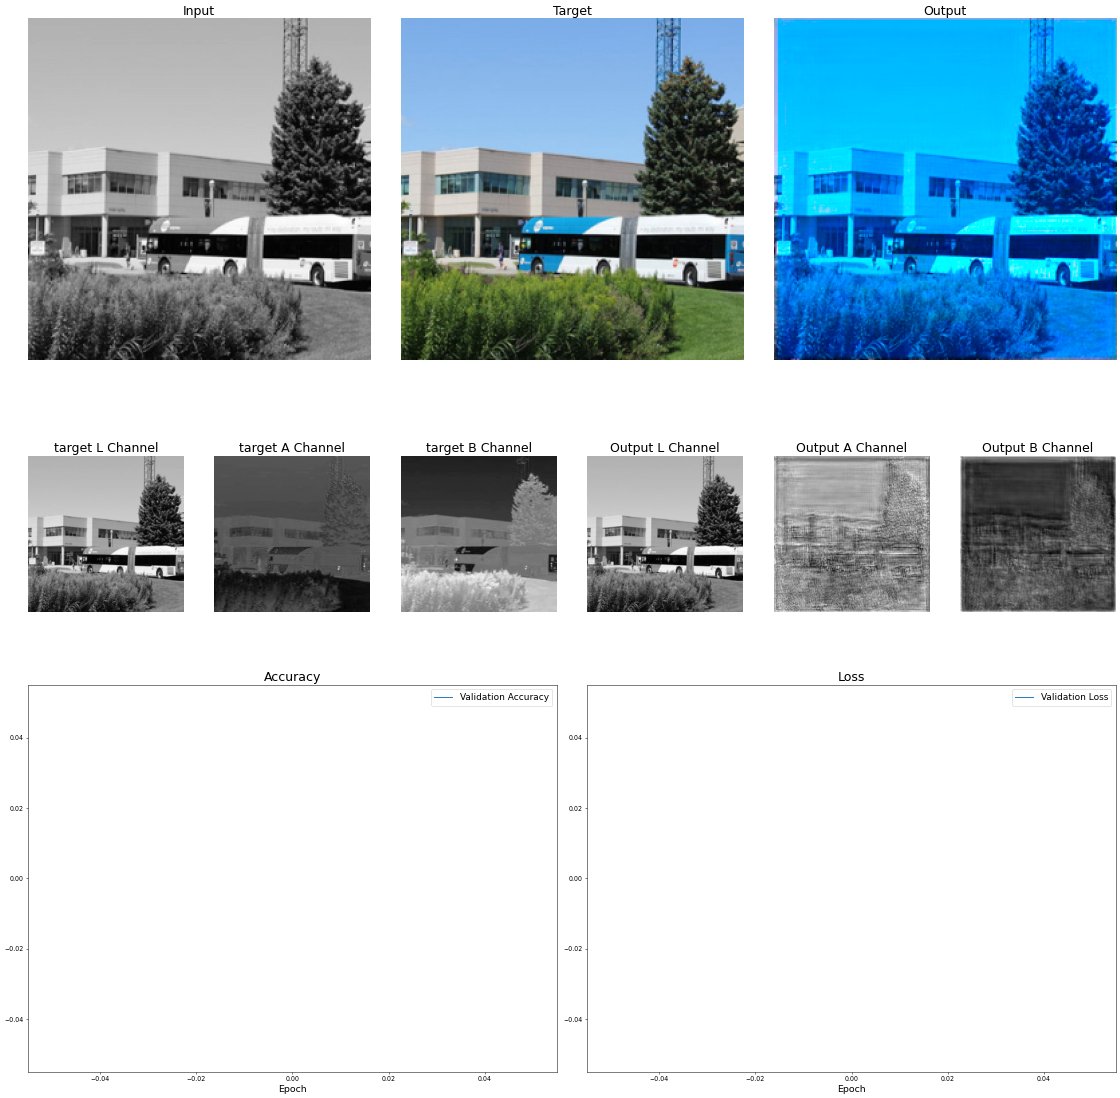

In [40]:
testResult(ColorNet(model, True, True, specs = specs), 25, f'{model_dir_name}/Results')

### Training

In [41]:
def fitLoop(epoch = 10, lr = 1e-4, skip = False):
    if not skip:
        optimizer.param_groups[0]['lr'] = lr
        fit(epoch, ColorNet(model, specs = specs), optimizer, train_dl, val_dl, metric)
        saveModelData(directory=model_dir_name)
        testResult(ColorNet(model, True, True, specs = specs), 25, model_dir_name)    


Epoch : [1/5], Loss : 0.23383, Accuracy : 0.93297523



Epoch : [2/5], Loss : 0.23203, Accuracy : 0.93451118



Epoch : [3/5], Loss : 0.22989, Accuracy : 0.93508524



Epoch : [4/5], Loss : 0.22884, Accuracy : 0.93493420



Epoch : [5/5], Loss : 0.22705, Accuracy : 0.93614894



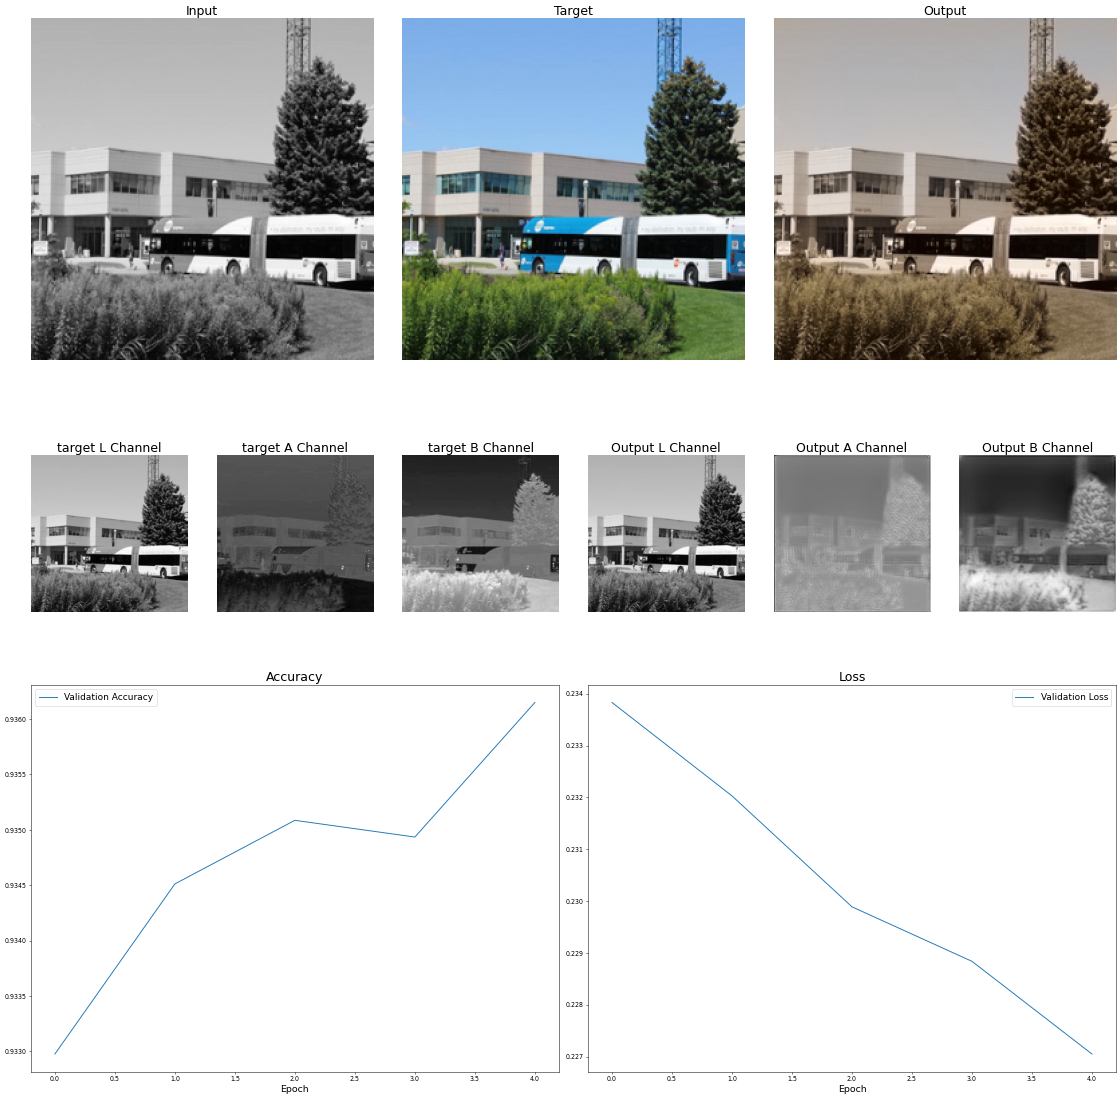

In [42]:
fitLoop(5, 1e-4)

In [ ]:
fitLoop(5, 1e-5)


Epoch : [1/5], Loss : 0.22245, Accuracy : 0.93656695


In [ ]:
fitLoop(5, 1e-5)

In [ ]:
# fitLoop(5, 1e-5)

## Result on TestData

In [ ]:
test_loss = 0
test_acc = 0

In [ ]:
# TEST ACCURACY
test_loss, total, test_acc = evaluate(ColorNet(model, True, specs = specs), test_dl, metric)
print(f"Loss : {test_loss:.4f}, Accuracy : {test_acc:.4f}")

In [ ]:
saveModelData(directory=model_dir_name, testScore = [test_loss, test_acc])

In [ ]:
# testResult(ColorNet(model.eval().cpu(), True, True, specs = specs), 75, model_dir_name, show=False)
# testResult(ColorNet(model.eval().cpu(), True, True, specs = specs), 1, model_dir_name, 'S1', show=False)
# testResult(ColorNet(model.eval().cpu(), True, True, specs = specs), 10, model_dir_name, 'S2', show=False)
# testResult(ColorNet(model.eval().cpu(), True, True, specs = specs), 25, model_dir_name, 'S3', show=False)
# testResult(ColorNet(model.eval().cpu(), True, True, specs = specs), 28, model_dir_name, 'S4', show=False)
# testResult(ColorNet(model.eval().cpu(), True, True, specs = specs), 42, model_dir_name, 'S5', show=False)

In [ ]:
img_idx = [1, 10, 25, 28, 42]
modelSampleOut(ColorNet(model, True, True, specs = specs), img_idx, f'{model_dir_name}/Results', saveTarget = False, result = [f'{test_loss:.6f}', f'{test_acc:.6f}'], show = True)

In [ ]:
samplesOut(ColorNet(model, True, True, specs = specs), img_idx, f'{model_dir_name}/Results', saveTarget = False, show = False)

In [ ]:
# samplesOut(ColorNet(model.eval().cpu(), True, True, specs = specs), img_idx, f'{model_dir_name}/Results', saveTarget = True, show = False, grayScale = True)

## RealLife Grayscale Image

In [ ]:
testDir = './RealTest/'
testImg = os.listdir(testDir)
img_dim = 256

In [ ]:
testImgs = []
for ti in testImg:
    timg = cv2.imread(f'{testDir}{ti}')
    timg = cv2.resize(timg, (img_dim, img_dim))
    timg = torch.from_numpy(timg).permute(2,0,1) / 255 - .5
    testImgs.append(timg[0].unsqueeze(0))

In [ ]:
testImgs = torch.stack(tuple(testImgs))

In [ ]:
fig = plt.subplots(1, 5, figsize=(50, 10), dpi=45)
graph_dim = (1, 5)

for i, ti in enumerate(testImgs):
    pltSubpot(graph_dim, (0, i), 1, '', ti.permute(1,2,0), titleShow=False)

In [ ]:
modelSampleOut(ColorNet(model, True, True, specs = specs), img_idx, f'{model_dir_name}/Results', saveTarget = False, result = [f'{test_loss:.6f}', f'{test_acc:.6f}'], show = True, realLife = testImgs)

In [ ]:
samplesOut(ColorNet(model, True, True, specs = specs), img_idx, f'{model_dir_name}/Results', saveTarget = False, show = False, realLife = testImgs)